<a href="https://colab.research.google.com/github/heewonLEE2/Data-Ai-Colab/blob/main/CIFAR10_%EC%B5%9C%EC%A2%85%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ CIFAR10 데이터셋으로 모델 학습 최종적으로 몇개의 하이퍼 파라미터를 수정한뒤 학습
- Optimizer: AdamW → SGD(momentum=0.9, nesterov=True, wd=5e-4), lr≈0.3(B=384 기준).
- Aug: RandAugment(num_ops=2)로 살짝 강화 + Cutout(16) 유지.
- MixUp: α=0.2 적용(손실은 두 타깃에 대한 CE 가중합).
- Val 분리: 검증은 증강 없이 test_tf 적용(성능/조기종료 판단 정확).
- Curves: 학습/검증 Loss·Acc 그래프 출력.

In [2]:
# =========================================================
# CIFAR-10 (SGD+Nesterov + RandAugment 강화 + MixUp + Curves)
# - 입력 32×32 유지 + CIFAR-stem ResNet18(from scratch)
# - Optim: SGD(momentum=0.9, nesterov=True), WD=5e-4
# - Aug: RandAugment(num_ops=2, magnitude=7) + Cutout(16)
# - MixUp(alpha=0.2)
# - AMP + CosineLR + Warmup + EarlyStopping
# - Val transform 분리(중요!) -> 과적합/성능 판단 정확
# =========================================================
!nvidia-smi -L || True

import os, math, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch import amp
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------------------------
# Config
# ---------------------------
SEED = 42
DATASET = 'CIFAR10'     # 'CIFAR10' or 'CIFAR100'
NUM_CLASSES = 10
EPOCHS = 30
BATCH_SIZE = 384        # 메모리 여유면 512도 시도
BASE_LR = 0.1 * (BATCH_SIZE / 128)  # SGD 권장 스케일링 -> 0.3 (B=384)
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
NESTEROV = True
LABEL_SMOOTH = 0.10
MIXUP_ALPHA = 0.2       # 0으로 두면 MixUp 끔
WARMUP_EPOCHS = 3
PATIENCE = 7
NUM_WORKERS = 2
PIN = True
PERSISTENT = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = (DEVICE=='cuda')

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

GPU 0: Tesla T4 (UUID: GPU-16fcbc40-d708-9d98-f42e-3c1c17e0aee7)


In [ ]:
# ---------------------------
# Utils
# ---------------------------
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=0.0):
        self.patience=patience; self.min_delta=min_delta; self.best=None; self.cnt=0; self.stop=False
    def step(self, v):
        if self.best is None or v < self.best - self.min_delta:
            self.best = v; self.cnt = 0
        else:
            self.cnt += 1
            if self.cnt >= self.patience: self.stop = True

def get_cosine_schedule_with_warmup(optimizer, num_warmup, num_training):
    def lr_lambda(step):
        if step < num_warmup: return float(step) / float(max(1, num_warmup))
        prog = float(step - num_warmup) / float(max(1, num_training - num_warmup))
        return 0.5 * (1.0 + math.cos(math.pi * prog))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

@torch.no_grad()
def accuracy(logits, y): return (logits.argmax(1) == y).float().mean().item()

def save_ckpt(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

In [ ]:
# ---------------------------
# Augmentations
# ---------------------------
class Cutout(object):
    def __init__(self, size=16): self.size = size
    def __call__(self, img):
        if not isinstance(img, torch.Tensor): return img
        c,h,w = img.shape
        cx = random.randint(0,w-1); cy = random.randint(0,h-1)
        half = self.size//2
        x1,y1 = max(0,cx-half), max(0,cy-half)
        x2,y2 = min(w,cx+half), min(h,cy+half)
        img[:, y1:y2, x1:x2] = 0.0
        return img

In [ ]:
# ---------------------------
# Data (val/test는 증강 없이!)
# ---------------------------
if DATASET == 'CIFAR100':
    DatasetClass = torchvision.datasets.CIFAR100
    NUM_CLASSES = 100
else:
    DatasetClass = torchvision.datasets.CIFAR10
    NUM_CLASSES = 10

mean = (0.4914, 0.4822, 0.4465); std = (0.2470, 0.2435, 0.2616)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=7),  # ← 강화
    T.ToTensor(),
    Cutout(size=16),
    T.Normalize(mean, std),
])
test_tf = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

# 전체 train 인덱스를 먼저 나눔
full_train = DatasetClass(root='./data', train=True, download=True, transform=None)
idx = np.arange(len(full_train)); np.random.shuffle(idx)
split = int(0.9 * len(idx))
train_idx, val_idx = idx[:split], idx[split:]

# 서로 다른 transform을 쓰는 두 개의 train-dataset 만들기
train_ds = DatasetClass(root='./data', train=True, download=False, transform=train_tf)
val_ds   = DatasetClass(root='./data', train=True, download=False, transform=test_tf)
test_ds  = DatasetClass(root='./data', train=False, download=True,  transform=test_tf)

# 같은 인덱스로 Subset
train_subset = torch.utils.data.Subset(train_ds, train_idx)
val_subset   = torch.utils.data.Subset(val_ds,   val_idx)

dl_kw = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=PERSISTENT)
if NUM_WORKERS and NUM_WORKERS > 0: dl_kw.update(prefetch_factor=2)
train_loader = DataLoader(train_subset, shuffle=True,  **dl_kw)
val_loader   = DataLoader(val_subset,   shuffle=False, **dl_kw)
test_loader  = DataLoader(test_ds,      shuffle=False, **dl_kw)

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


In [ ]:
# ---------------------------
# Model (CIFAR-stem ResNet18)
# ---------------------------
from torchvision import models
class CIFARResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        m = models.resnet18(weights=None)
        m.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        m.maxpool = nn.Identity()
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        self.m = m
    def forward(self,x): return self.m(x)

model = CIFARResNet18(NUM_CLASSES).to(DEVICE)
if DEVICE=='cuda': model = model.to(memory_format=torch.channels_last)

In [ ]:
# ---------------------------
# Optim / Loss / Scheduler / AMP
# ---------------------------
opt = optim.SGD(model.parameters(),
                lr=BASE_LR, momentum=MOMENTUM,
                weight_decay=WEIGHT_DECAY, nesterov=NESTEROV)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
scaler = GradScaler(enabled=(DEVICE=='cuda'))

total_steps = EPOCHS * len(train_loader)
warmup_steps = max(1, WARMUP_EPOCHS * len(train_loader))
scheduler = get_cosine_schedule_with_warmup(opt, warmup_steps, total_steps)

/tmp/ipython-input-334776419.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=='cuda'))


## **Mixup-helper 란 배치 안에서 두 샘플을 섞어 학습용 입력/타깃을 만들고, 그에 맞는 손실을 계산하는 유틸이에요.**


1. mixup_data(x, y, alpha)
    - λ ~ Beta(α, α) 를 샘플링(0~1).

   - 배치 인덱스를 무작위로 섞어 (x_i, y_i)와 (x_j, y_j)를 짝지음.

   - 입력 섞기: x_mix = λ·x_i + (1-λ)·x_j

   - 라벨은 두 개를 따로 보관: y_a = y_i, y_b = y_j (원-핫으로 만들지 않음)

  - (x_mix, y_a, y_b, λ) 반환
→ α=0이면 바로 (x, y, y, 1.0)을 돌려 MixUp 비활성화.

2. mixup_criterion(criterion, pred, y_a, y_b, lam)

    - 일반 CrossEntropyLoss는 원-핫을 기대하지 않으므로,
    두 개의 CE를 λ와 (1-λ)로 가중합:
    L = λ·CE(pred, y_a) + (1-λ)·CE(pred, y_b)
    → 원-핫 없이도 부드러운 타깃(soft label) 효과를 구현.

## (효과)
- 강한 정규화: 결정 경계를 매끄럽게 → 과적합/라벨 노이즈에 더 강함.
- 일반화↑/칼리브레이션 개선: CIFAR 같은 과제에서 수%p 이득 기대.

## 학습 루프에서의 위치

- 배치 텐서를 GPU로 옮긴 뒤 mixup_data로 섞고, 섞인 입력으로 forward → mixup_criterion으로 손실 계산 → backward/step.

- 정확도는 원본 배치(x, y) 로 별도 평가(코드가 그렇게 되어 있음).
(MixUp 샘플은 라벨이 두 개라 “정확도” 정의가 애매하므로.)

## 하이퍼파라미터 팁

- α=0.2~0.4가 보통 무난. 너무 크면(강한 혼합) 언더피팅 가능.

- 일부 구현은 lam = max(lam, 1-lam)으로 한 쪽 비중을 항상 ≥0.5로 둡니다(선택).

## 주의/호환

- Cutout, RandAugment와 함께 써도 OK(보통 상호보완).

- Label Smoothing과도 동작(CE 호출이라 문제 없음).

- BCE/멀티라벨이면 손실 함수를 BCE 기반으로 바꿔 동일 아이디어 적용.

- 배치가 너무 작으면(예: 1) 섞을 페어가 없어 효과가 줄어듭니다.

> 요약: 이 헬퍼 둘은 입력/라벨을 선형 섞고(데이터), 그에 맞춰 손실도 선형 섞는(학습) MixUp의 핵심 구현이에요.

In [ ]:
# ---------------------------
# MixUp helper
# ---------------------------
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0.0: return x, y, y, 1.0
    lam = float(np.random.beta(alpha, alpha))
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
# ---------------------------
# Train / Eval (history 기록)
# ---------------------------
CKPT = '/content/best_cifar_sgd_mixup.pt'
early = EarlyStopping(patience=PATIENCE)

history = {'tr_loss':[], 'tr_acc':[], 'va_loss':[], 'va_acc':[], 'epoch_time':[]}

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0; total_acc = 0.0; n = 0
    for x,y in loader:
        if DEVICE=='cuda':
            x = x.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last)
        else:
            x = x.to(DEVICE)
        y = y.to(DEVICE, non_blocking=True)

        if train:
            opt.zero_grad(set_to_none=True)
            # ---- MixUp ----
            xm, ya, yb, lam = mixup_data(x, y, MIXUP_ALPHA)
            with amp.autocast(device_type='cuda', enabled=(DEVICE=='cuda')):
                logits = model(xm)
                loss = mixup_criterion(criterion, logits, ya, yb, lam) if MIXUP_ALPHA>0 else criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()
            # 정확도는 원본 배치로 평가(참고용)
            with torch.no_grad():
                logits_eval = model(x)
                acc = accuracy(logits_eval, y)
        else:
            with torch.no_grad():
                logits = model(x)
                loss = criterion(logits, y)
                acc = accuracy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        n += bs
    return total_loss / n, total_acc / n

best_val = float('inf')
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    dt = time.time() - t0

    history['tr_loss'].append(tr_loss); history['tr_acc'].append(tr_acc)
    history['va_loss'].append(va_loss); history['va_acc'].append(va_acc)
    history['epoch_time'].append(dt)

    if va_loss < best_val:
        best_val = va_loss
        save_ckpt(model, CKPT)

    early.step(va_loss)
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} | {dt:.1f}s")
    if early.stop:
        print("Early stopping.")
        break

[01/30] train_loss=2.2280 acc=0.2868 | val_loss=2.1778 acc=0.2922 | 52.4s
[02/30] train_loss=1.8965 acc=0.4596 | val_loss=2.0343 acc=0.3488 | 39.5s
[03/30] train_loss=1.7088 acc=0.5852 | val_loss=2.1157 acc=0.4102 | 38.9s
[04/30] train_loss=1.5930 acc=0.6599 | val_loss=1.7499 acc=0.4668 | 38.9s
[05/30] train_loss=1.4520 acc=0.7213 | val_loss=2.2092 acc=0.3894 | 38.0s
[06/30] train_loss=1.4582 acc=0.7465 | val_loss=1.6673 acc=0.5288 | 38.4s
[07/30] train_loss=1.3730 acc=0.7795 | val_loss=1.4633 acc=0.5990 | 39.0s
[08/30] train_loss=1.4223 acc=0.7856 | val_loss=1.1927 acc=0.7030 | 39.1s
[09/30] train_loss=1.3000 acc=0.8150 | val_loss=1.0087 acc=0.7866 | 38.5s
[10/30] train_loss=1.3337 acc=0.8172 | val_loss=1.0430 acc=0.7636 | 38.8s
[11/30] train_loss=1.2900 acc=0.8300 | val_loss=1.1309 acc=0.7438 | 39.0s
[12/30] train_loss=1.2827 acc=0.8401 | val_loss=1.1067 acc=0.7492 | 38.8s
[13/30] train_loss=1.2562 acc=0.8499 | val_loss=1.0937 acc=0.7474 | 38.8s
[14/30] train_loss=1.2852 acc=0.8488 |

In [ ]:
# ---------------------------
# Test with best
# ---------------------------
model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
model.eval()
@torch.no_grad()
def eval_loader(loader):
    tl, ta, n = 0.0, 0.0, 0
    for x,y in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        tl += loss.item() * bs; ta += accuracy(logits,y) * bs; n += bs
    return tl/n, ta/n

te_loss, te_acc = eval_loader(test_loader)
print(f"Test: loss={te_loss:.4f}, acc={te_acc:.4f}")

Test: loss=0.6678, acc=0.9272


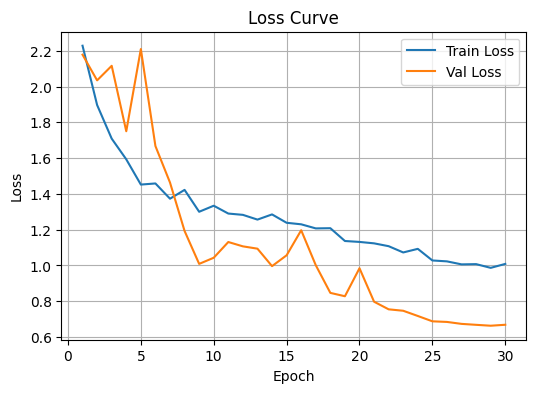

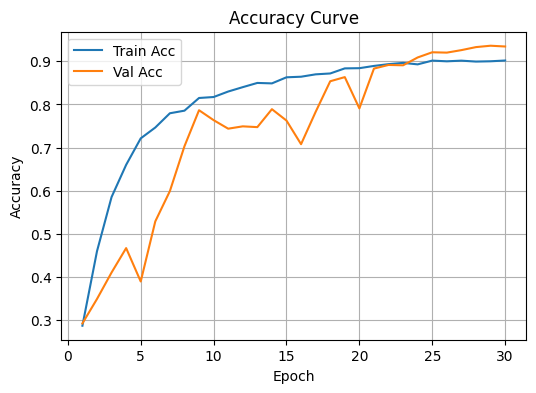

In [ ]:
# ---------------------------
# Curves (Loss / Accuracy)
# ---------------------------
epochs = range(1, len(history['tr_loss'])+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history['tr_loss'], label='Train Loss')
plt.plot(epochs, history['va_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history['tr_acc'], label='Train Acc')
plt.plot(epochs, history['va_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.grid(True); plt.legend(); plt.show()

In [ ]:
# 선택사항! : 메타까지 묶어서 한 파일로 저장
torch.save({
    "state_dict": model.state_dict(),
    "arch": "cifar_resnet18_stem",
    "classes": ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],
    "mean": (0.4914, 0.4822, 0.4465),
    "std":  (0.2470, 0.2435, 0.2616),
}, "/content/cifar10_resnet18_bundle.pt")

In [3]:
# 각각의 폴더 만들기
CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for fileName in CLASSES :
    os.mkdir('/content/my_images/' + fileName)

In [4]:
# ===== 폴더명(=정답) 기반 평가 확장 =====
# 폴더 구조 예: /content/my_images/<class_name>/image.jpg
# CLASSES와 폴더명이 정확히 일치해야 해요. (자동 보정 맵 몇 개는 포함)

import os, re, glob
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch import amp
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
from PIL import Image

image_dir = "/content/my_images"                      # 이미지 폴더
ckpt_path = "/content/best_cifar_sgd_mixup.pt"        # 가중치 경로
batch_size = 64
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
class_to_idx = {c:i for i,c in enumerate(CLASSES)}

# 폴더명 보정(간단한 동의어/표기 통일)
CANON = {
    "car":"automobile", "autos":"automobile", "motorcar":"automobile",
    "aeroplane":"airplane"
}
def canonicalize(label):
    lab = label.strip().lower()
    lab = lab.replace(" ", "").replace("-", "").replace("_","")
    lab = CANON.get(lab, lab)
    return lab

# 전처리(추론용)
mean=(0.4914,0.4822,0.4465); std=(0.2470,0.2435,0.2616)
test_tf = T.Compose([T.Resize((32,32)), T.ToTensor(), T.Normalize(mean,std)])

# 모델(CIFAR-stem ResNet18)
def build_cifar_resnet18(num_classes=10):
    m = models.resnet18(weights=None)
    import torch.nn as nn
    m.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model = build_cifar_resnet18(10).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
state = ckpt.get("state_dict", ckpt)
# 접두사 정리(학습 시 래퍼가 있었다면)
def strip_prefix(d, prefix):
    return { (k[len(prefix):] if k.startswith(prefix) else k): v for k,v in d.items() }
state = strip_prefix(strip_prefix(state, "module."), "m.")
model.load_state_dict(state, strict=True)
model.eval()

# 파일 리스트업(+ 정답 라벨 추출)
def list_images(root):
    exts=("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG")
    files=[]
    for e in exts: files.extend(glob.glob(os.path.join(root,"**",e), recursive=True))
    return sorted(files)

files = list_images(image_dir)
assert files, f"No images in {image_dir}"

def true_label_from_path(p):
    true_raw = os.path.basename(os.path.dirname(p))    # 상위 폴더명
    lab = canonicalize(true_raw)
    if lab not in class_to_idx:
        raise ValueError(f"Unknown class folder: '{true_raw}' -> '{lab}'. "
                         f"Expected one of {list(class_to_idx)}")
    return lab, class_to_idx[lab]

# 데이터셋
class ImageWithLabelDS(Dataset):
    def __init__(self, filepaths, tf):
        self.files = filepaths; self.tf = tf
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        p = self.files[i]
        img = Image.open(p).convert("RGB")
        x = self.tf(img)
        y_name, y_idx = true_label_from_path(p)
        return x, p, y_idx, y_name

ds = ImageWithLabelDS(files, test_tf)
dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                num_workers=num_workers, pin_memory=(device=="cuda"),
                persistent_workers=False)

rows=[]; softmax = nn.Softmax(dim=1)

@torch.no_grad()
def in_topk(probs_row, true_idx, k=5):
    return true_idx in np.argsort(-probs_row)[:k]

with torch.no_grad():
    for x, paths, y_idx, y_name in dl:
        x = x.to(device, non_blocking=True)
        with amp.autocast(device_type='cuda', enabled=(device=='cuda')):
            logits = model(x)
            probs = softmax(logits).cpu().numpy()
        topk = 5
        topv, topi = torch.topk(torch.from_numpy(probs), k=topk, dim=1)
        for pth, ti, tv, yi, yn in zip(paths, topi.tolist(), topv.tolist(), y_idx.tolist(), y_name):
            preds = [CLASSES[j] for j in ti]
            row = {
                "filename": os.path.relpath(pth, image_dir),
                "true": yn,
                "pred1": preds[0], "prob1": float(tv[0]),
                "pred2": preds[1], "prob2": float(tv[1]),
                "pred3": preds[2], "prob3": float(tv[2]),
                "pred4": preds[3], "prob4": float(tv[3]),
                "pred5": preds[4], "prob5": float(tv[4]),
            }
            row["correct_top1"] = (row["pred1"] == yn)
            row["correct_top5"] = in_topk(probs[0*0:1].reshape(-1), yi, k=5) if False else (yn in preds[:5])
            rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("/content/preds_with_labels.csv", index=False, encoding="utf-8")
print("Saved /content/preds_with_labels.csv")

# 전체/클래스별 정확도
top1 = df["correct_top1"].mean()
top5 = df["correct_top5"].mean()
print(f"Top-1 acc: {top1:.4f}  |  Top-5 acc: {top5:.4f}")

per_class = df.groupby("true")["correct_top1"].mean().reindex(CLASSES)
print("\nPer-class Top-1 accuracy:")
print(per_class)

# 간단 혼동 행렬(Top-1 기준)
import numpy as np
cm = np.zeros((len(CLASSES), len(CLASSES)), dtype=int)
for _, r in df.iterrows():
    i = class_to_idx[r["true"]]
    j = class_to_idx[r["pred1"]]
    cm[i, j] += 1
print("\nConfusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=CLASSES, columns=CLASSES))

Saved /content/preds_with_labels.csv
Top-1 acc: 0.9038  |  Top-5 acc: 1.0000

Per-class Top-1 accuracy:
true
airplane      1.000000
automobile    0.714286
bird          0.600000
cat           1.000000
deer          1.000000
dog           0.818182
frog          1.000000
horse         1.000000
ship          0.928571
truck         0.900000
Name: correct_top1, dtype: float64

Confusion Matrix (rows=true, cols=pred):
            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
airplane          11           0     0    0     0    0     0      0     0   
automobile         0           5     0    0     0    0     0      0     0   
bird               2           0     6    0     0    1     0      0     1   
cat                0           0     0   13     0    0     0      0     0   
deer               0           0     0    0    11    0     0      0     0   
dog                0           0     0    1     0    9     0      1     0   
frog               0           0     0    0  